# Most Reliable Path

Most Reliable Path (MRP) is a variant of the Shortest Path Problem, where, each edge is
randomly associated with probabilities (0.512 or 0.8) which denotes the “reliability” of the edge,
and the task is to find the most reliable path between the source and the destination node. We
do not remove edges this time.

We use the same 5-layer MLP in the SP experiment as the baseline. We also use the simplepath and the reachability constraints to train the neural network by DeepLPMLN. Besides, we
use weak constraints to represent the probability of each edge in the grid.

## Imports

In [8]:
import sys
sys.path.append("../../")
from dlpmln import DeepLPMLN
import torch
from torch.autograd import Variable
import numpy as np
import time
from network import FC
from dataGen import GridProbData
import random

## Define dprogram and dprogram_test

In [9]:
dprogram = '''
grid(g).
nn(m(g,24), nn_edge, [t,f]) :- grid(g).
sp(0,1) :- nn_edge(g, 0, t).
sp(1,2) :- nn_edge(g, 1, t).
sp(2,3) :- nn_edge(g, 2, t).
sp(4,5) :- nn_edge(g, 3, t).
sp(5,6) :- nn_edge(g, 4, t).
sp(6,7) :- nn_edge(g, 5, t).
sp(8,9) :- nn_edge(g, 6, t).
sp(9,10) :- nn_edge(g, 7, t).
sp(10,11) :- nn_edge(g, 8, t).
sp(12,13) :- nn_edge(g, 9, t).
sp(13,14) :- nn_edge(g, 10, t).
sp(14,15) :- nn_edge(g, 11, t).
sp(0,4) :- nn_edge(g, 12, t).
sp(4,8) :- nn_edge(g, 13, t).
sp(8,12) :- nn_edge(g, 14, t).
sp(1,5) :- nn_edge(g, 15, t).
sp(5,9) :- nn_edge(g, 16, t).
sp(9,13) :- nn_edge(g, 17, t).
sp(2,6) :- nn_edge(g, 18, t).
sp(6,10) :- nn_edge(g, 19, t).
sp(10,14) :- nn_edge(g, 20, t).
sp(3,7) :- nn_edge(g, 21, t).
sp(7,11) :- nn_edge(g, 22, t).
sp(11,15) :- nn_edge(g, 23, t).
sp(X,Y) :- sp(Y,X).
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

dprogram_test = '''
grid(g).
sp(0,1) :- nn_edge(g, 0, t).
sp(1,2) :- nn_edge(g, 1, t).
sp(2,3) :- nn_edge(g, 2, t).
sp(4,5) :- nn_edge(g, 3, t).
sp(5,6) :- nn_edge(g, 4, t).
sp(6,7) :- nn_edge(g, 5, t).
sp(8,9) :- nn_edge(g, 6, t).
sp(9,10) :- nn_edge(g, 7, t).
sp(10,11) :- nn_edge(g, 8, t).
sp(12,13) :- nn_edge(g, 9, t).
sp(13,14) :- nn_edge(g, 10, t).
sp(14,15) :- nn_edge(g, 11, t).
sp(0,4) :- nn_edge(g, 12, t).
sp(4,8) :- nn_edge(g, 13, t).
sp(8,12) :- nn_edge(g, 14, t).
sp(1,5) :- nn_edge(g, 15, t).
sp(5,9) :- nn_edge(g, 16, t).
sp(9,13) :- nn_edge(g, 17, t).
sp(2,6) :- nn_edge(g, 18, t).
sp(6,10) :- nn_edge(g, 19, t).
sp(10,14) :- nn_edge(g, 20, t).
sp(3,7) :- nn_edge(g, 21, t).
sp(7,11) :- nn_edge(g, 22, t).
sp(11,15) :- nn_edge(g, 23, t).
sp(X,Y) :- sp(Y,X).
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

## Dataset

A GridProbData object with 6 attributes: train_data, test_data, valid_data, train_labels,  

test_labels, valid_labels  
train_data is an numpy array of size (1800, 40). It consists of 1800 data as follows 

>[  
data,  
...,  
data  
]  

where data is a vector (numpy array) of length 40. For example, the data shown below  
>        [  
        0.512 0.8 0.512 0.8 0.512  
        0.512 0.8 0.512 0.512 0.8  
        0.8 0.512 0.512 0.8 0.512  
        0.512 0.512 0.512 0.512 0.8  
        0.512 0.8 0.512 0.8  
        10000 00000 01000 0  
        ]  

defines the 24 probabilities of the 24 edges and specified that the nodes 0 and 11 are  
the starting and ending nodes.  
train_labels is an numpy array of size (1800, 24). It consists of 1800 label as follows.  
>[  
label,  
...,  
label  
]  

where label is a vector (numpy array) of length 24. For example, the label shown below  
>[  
11100 00000 00000 00000 0110  
]  

means that the edges 0, 1, 2, 21, 22 form a most reliable path.  
test_data is a numpy array of size (600, 40).  
valid_data is a numpy array of size (600, 40).  
test_labels is a numpy array of size (600, 24).  
valid_labels is a numpy array of size (600, 24).  



## Create Neural Network 

In [10]:
m = FC(40, *[50, 50, 50, 50, 50], 24)

nnMapping = {'m': m}

optimizer = {'m':torch.optim.Adam(m.parameters(), lr=0.001)}

Neural Network (MLP) Structure: (40, 50, 50, 50, 50, 50, 24)


## Create DeepLPMLN object

In [11]:
dlpmlnObj = DeepLPMLN(dprogram, nnMapping, optimizer)

## Process the data

In [12]:
 
dataset = GridProbData("data/data.txt")
dataList = []
obsList = []

there are 3000 data in total, 60% training data, 20% validation data, 20% testing data!


### Populate dataList and obsList

In [13]:
for i, d in enumerate(dataset.train_data):
    d_tensor = Variable(torch.from_numpy(d).float(), requires_grad=False)
    dataList.append({"g": d_tensor})

    
with open("data/evidence_train.txt", 'r') as f:
    obsList = f.read().strip().strip("#evidence").split("#evidence")

Do the same for the test data.

In [14]:
testData = []
testObsLost = []

for d in dataset.test_data:
    d_tensor = Variable(torch.from_numpy(d).float(), requires_grad=False)
    testData.append({"g": d_tensor})
    


with open("data/evidence_test.txt", 'r') as f:
    testObsLost = f.read().strip().strip("#evidence").split("#evidence")





## Training and testing

In [ ]:

dlpmlnObj.learn(dataList = dataList, obsList = obsList, epoch=200, opt=True)
dlpmlnObj.testConstraint(testData, testObsLost,[dprogram_test])

Training for epoch 1 ...
Training for epoch 2 ...
Training for epoch 3 ...
Training for epoch 4 ...
Training for epoch 5 ...
Training for epoch 6 ...
Training for epoch 7 ...
Training for epoch 8 ...
Training for epoch 9 ...
Training for epoch 10 ...
Training for epoch 11 ...
Training for epoch 12 ...
Training for epoch 13 ...
Training for epoch 14 ...
Training for epoch 15 ...
Training for epoch 16 ...
Training for epoch 17 ...
Training for epoch 18 ...
Training for epoch 19 ...
Training for epoch 20 ...
Training for epoch 21 ...
Training for epoch 22 ...
Training for epoch 23 ...
Training for epoch 24 ...
Training for epoch 25 ...
Training for epoch 26 ...
Training for epoch 27 ...
Training for epoch 28 ...
Training for epoch 29 ...
Training for epoch 30 ...
Training for epoch 31 ...
Training for epoch 32 ...
Training for epoch 33 ...
Training for epoch 34 ...
Training for epoch 35 ...
Training for epoch 36 ...
Training for epoch 37 ...
Training for epoch 38 ...
Training for epoch 39

## Comparison

The following table compares the different accuracies on the test data between MLP Only
trained by cross entropy loss and the same MLP trained by DeepLPMLN. 

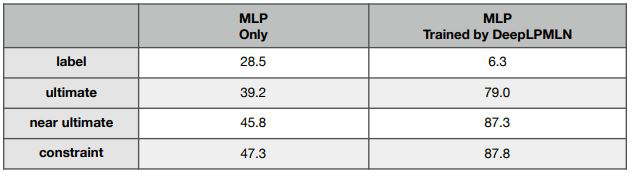

In [17]:
from IPython.display import display
from PIL import Image


path="accuracy_comparison.jpg"
display(Image.open(path))

In the above table, the label accuracy is the measure against the label for which the neural
network is trained for. Note that the MRP problem (and the SP and the top K in the next
section) are not “functional” problems in the sense that there may be multiple solutions
possible. In such a case, we select only one among them as the label in the training set to be in
favor of neural network learning.

However, it is possible that the prediction different from the label is still correct. To account for
this, we consider the ultimate accuracy, which counts such prediction correct. The near
ultimate accuracy is similar but a bit more relaxed. It allows more predictions to be correct by
including near optimal paths in which the number of edges is the same as that of a most
reliable path but a 0.512 edge is contained instead of a 0.8 edge.

The constraint accuracy counts if the prediction satisfies the simple-path and the reachability
constraints regardless whether it’s most reliable or not.
